In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class SpectralResidual:
    def __init__(
        self, 
        threshold, 
        mag_window, 
        sliding_window, 
        num_predictions,
        pred_lookback,
    ):
        self.threshold = threshold
        self.mag_window = mag_window
        self.sliding_window = sliding_window
        self.num_predictions = num_predictions
        self.pred_lookback = pred_lookback
    
    def predict_next(self, values):
        """
        Predicts the next value by sum up the slope of the last value with previous values.
        Mathematically, g = 1/m * sum_{i=1}^{m} g(x_n, x_{n-i}), x_{n+1} = x_{n-m+1} + g * m,
        where g(x_i,x_j) = (x_i - x_j) / (i - j)
        :param values: list.
            a list of float numbers.
        :return : float.
            the predicted next value.
        """

        if len(values) <= 1:
            raise ValueError(f'data should contain at least 2 numbers')

        v_last = values[-1]
        n = len(values)

        slopes = [(v_last - v) / (n - 1 - i) for i, v in enumerate(values[:-1])]

        return values[-self.pred_lookback] + sum(slopes)
    
    def extend_series(self, values):
        """
        extend the array data by the predicted next value
        :param values: list.
            a list of float numbers.
        :param extend_num: int, default 5.
            number of values added to the back of data.
        :param look_ahead: int, default 5.
            number of previous values used in prediction.
        :return: list.
            The result array.
        """

        if self.pred_lookback < 1:
            raise ValueError('look_ahead must be at least 1')

        extension = [self.predict_next(values[-self.pred_lookback - 2:-1])] * self.num_predictions
        
        return np.concatenate((values, extension), axis=0)
    
    @staticmethod
    def average_filter(values, n=3):
        """
        Calculate the sliding window average for the give time series.
        Mathematically, res[i] = sum_{j=i-t+1}^{i} values[j] / t, where t = min(n, i+1)
        :param values: list.
            a list of float numbers
        :param n: int, default 3.
            window size.
        :return res: list.
            a list of value after the average_filter process.
        """

        if n >= len(values):
            n = len(values)

        res = np.cumsum(values, dtype=float)
        res[n:] = res[n:] - res[:-n]
        res[n:] = res[n:] / n

        for i in range(1, n):
            res[i] /= (i + 1)

        return res
    
    def spectral_residual_transform(self, values):
        """
        This method transform a time series into spectral residual series
        :param values: list.
            a list of float values.
        :return: mag: list.
            a list of float values as the spectral residual values
        """

        trans = np.fft.fft(values)
        mag = np.sqrt(trans.real ** 2 + trans.imag ** 2)
        eps_index = np.where(mag <= 1e-8)[0]
        mag[eps_index] = 1e-8

        mag_log = np.log(mag)
        mag_log[eps_index] = 0

        spectral = np.exp(mag_log - SpectralResidual.average_filter(mag_log, n=self.mag_window))

        trans.real = trans.real * spectral / mag
        trans.imag = trans.imag * spectral / mag
        trans.real[eps_index] = 0
        trans.imag[eps_index] = 0

        wave_r = np.fft.ifft(trans)
        mag = np.sqrt(wave_r.real ** 2 + wave_r.imag ** 2)
        
        return mag
    
    def generate_spectral_score(self, mags):
        ave_mag = SpectralResidual.average_filter(mags, n=self.sliding_window)
        safeDivisors = np.clip(ave_mag, 1e-8, ave_mag.max())

        raw_scores = np.abs(mags - ave_mag) / safeDivisors
        scores = np.clip(raw_scores / 10.0, 0, 1.0)

        return scores
    
    def detect(self, values):
        extended_series = self.extend_series(values)
        mags = self.spectral_residual_transform(extended_series)
        anomaly_scores = self.generate_spectral_score(mags)
        pred = anomaly_scores[-self.num_predictions - 1] > self.threshold
        
        return pred

In [3]:
ts = np.array(pd.read_csv('ts.csv')).flatten()

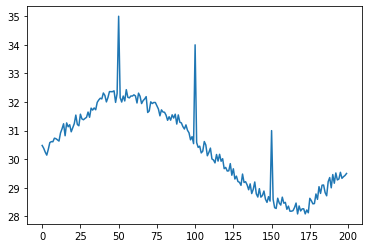

In [4]:
plt.plot(ts)

In [5]:
sliding_window_size = 30
n = len(ts)
X = []
for i in range(n - sliding_window_size + 1):
    X.append(ts[i:i + sliding_window_size])

In [6]:
sr = SpectralResidual(0.3, 30, 30, 5, 5)
m = len(X)

In [7]:
predictions = []
for candidate in X:
    predictions.append(sr.detect(candidate))

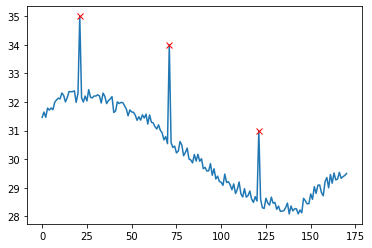

In [8]:
fig, ax = plt.subplots()
ax.plot(ts[-m:])
for idx, anomaly in enumerate(predictions):
    if anomaly:
        ax.plot(idx, ts[sliding_window_size + idx - 1], marker='x', color='r')